In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
import os
import numpy as np

file_path = './test_files/3Dblood27.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.300000,11.197390,3.047941,0,0,0
1,4.200000,11.197390,3.047941,0,0,0
2,4.100000,11.197390,3.047941,0,0,0
3,4.000000,11.197390,3.047941,0,0,0
4,3.900000,11.197390,3.047941,0,0,0
...,...,...,...,...,...,...
1799,4.324351,10.356519,3.886832,255,0,255
1800,4.253031,10.706822,3.538061,255,0,255
1801,4.260648,10.636221,3.608462,255,0,255
1802,4.295052,11.128907,3.116422,255,0,255


In [41]:
def distance_calculator(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removes the jump and makes the line continuous
    # Note this seems very fragile and I probably need add a second check for large jumps at the end of the code
    if shape.iloc[-1]['distance_from_last'] > 2.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

def midlinejumpsplitter(shape):
    # This needs generalising to lines with more than 2 jumps
    id = shape['line_id'].unique()[0]
    # Split the line at the index - at the moment uses a completely arbitrary distance of 2mm
    split_index = shape[shape['distance_from_last'] > 2.].index[0]
    shape1 = shape.iloc[:split_index]
    shape1['line_id'] = 1
    shape1['distance_from_last'].iloc[0] = np.nan
    shape2 = shape.iloc[split_index:]
    shape2['line_id'] = 2
    shape2['distance_from_last'].iloc[0] = np.nan
    return shape1, shape2

def shapesplitter(df):
    # Identify line IDs that have large jumps in the middle
    line_ids = np.sort(df['line_id'].unique())   # Sorting makes life easier later
    line_ids_new = line_ids.copy()   # A list of line IDs that we're going to update
    for line_id in line_ids:
        shape = df[df['line_id'] == line_id]
        if shape['distance_from_last'].max() > 2.:
            shape1, shape2 = midlinejumpsplitter(shape)
            df  = df[df['line_id'] != line_id] 
            line_ids_new = line_ids_new[line_ids_new != line_id]
            line_ids_new = np.append(line_ids_new, [line_ids_new[-1]+1, line_ids_new[-1]+2])
            shape1['line_id'], shape2['line_id'] = line_ids_new[-2], line_ids_new[-1]
            shape = pd.concat([shape1, shape2])
            df = pd.concat([df, shape])  
    return df

def node_finder(df):
    # Use hierarchical clustering to note common start / end points
    # Calculate node positions based on cluster centroids
    # Append centroids to start / end of each line
    start_points = df.groupby('line_id').first() # First point of each line
    end_points = df.groupby('line_id').last() # Last
    terminal_points = pd.concat([start_points, end_points])   # Combine the two
    dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
    link_mat = hier.linkage(dist_mat)
    # fcluster assigns each of the particles in positions a cluster to which it belongs
    cluster_idx = hier.fcluster(link_mat, t=1, criterion='distance')   # t defines the max cophonetic distance in a cluster
    terminal_points['cluster'] = cluster_idx

    # Calculate the mean position of each cluster
    nodes = terminal_points.groupby('cluster').mean()
    for n in terminal_points.index.unique():
        clusters = terminal_points.loc[n]['cluster']
        for c in clusters:
            new_point = nodes.loc[c:c]
            line = df[df['line_id'] == n]
            line_start = line.head(1)
            line_end = line.tail(1)
            new_point[['r', 'g', 'b', 'line_id']] = line_start[['r', 'g', 'b', 'line_id']].values

            start_sep = dist.euclidean(new_point[['x', 'y', 'z']].values[0], line_start[['x', 'y', 'z']].values[0])
            end_sep = dist.euclidean(new_point[['x', 'y', 'z']].values[0], line_end[['x', 'y', 'z']].values[0])
            if start_sep < end_sep:
                line = pd.concat([new_point, line]) 
            elif start_sep > end_sep:
                line = pd.concat([line, new_point])
            
            df = df[df['line_id'] != n]
            df = pd.concat([df, line])
            df = df.reset_index(drop=True)
            df = distance_calculator(df)
            
            # Set distance from last to NaN for the first row of each line
            df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan
    return df, terminal_points, nodes

def line_plotter(df):
    # Plots lines assigning a colour to each line_id
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for n in np.unique(df['line_id'].values):
        ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

    # If you need a specific line plotting
    # n = 2
    # ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z']

    for n in np.unique(terminal_points['cluster'].values):
        ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

    ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
    plt.show()


def eulerficator(df, terminal_points, nodes):
    terminal_points_nogroups = terminal_points.reset_index()
    clusters = terminal_points_nogroups['cluster'].unique()
    lines = terminal_points_nogroups['line_id'].unique()

    # Run through each cluster and create two dictionaries 
    # 1 - cluster numbers as key and the connecting lines as values
    # 2 - cluster numbers as key and the number of connecting nodes as values
    cluster_dict = {}
    connectivity_dict = {}
    for c in clusters:
        connecting_lines = terminal_points_nogroups[terminal_points_nogroups['cluster'] == c]
        cluster_dict[c] = list(connecting_lines['line_id'].values)

        connectivity_dict[c] = len(connecting_lines)

    line_order = []
    while len(line_order) < len(lines):
        # Sort lines by height order - bottom up
        min_z = df.groupby('line_id')['z'].min()
        heightsorted_line_ids = min_z.sort_values().index.tolist()
        unprinted_lines = [n for n in heightsorted_line_ids if n not in line_order]

        # Pick the unprinted line with the lowest z-value to start with
        next_line = unprinted_lines[0]
        line_order.append(next_line)
        unprinted_lines = unprinted_lines[1:] # Remove the printed line from the list of remaining lines

        # Calculate which node you're at - it's the other node to which next_line is connected
        connected_nodes = terminal_points.loc[next_line]['cluster'].values

        # Pick the node with the lower z-value
        start_node = nodes.loc[connected_nodes]['z'].idxmin()
        end_node = connected_nodes[connected_nodes != start_node][0]

        connected_lines = cluster_dict[end_node]
        # Calculate unprinted connected lines in height-order
        connected_lines = [n for n in unprinted_lines if n in connected_lines]
        while len(connected_lines) > 0:
            next_line = connected_lines[0]
            line_order.append(next_line)
            unprinted_lines.remove(next_line)
            # Calculate which node you've moved to
            connected_nodes = terminal_points.loc[next_line]['cluster'].values
            start_node = end_node
            end_node = connected_nodes[connected_nodes != start_node][0]
            connected_lines = cluster_dict[end_node]

            # Remove lines that have already been printed
            connected_lines = [n for n in unprinted_lines if n in connected_lines]
    return line_order
    
# Calculate the distance between consecutive points
df = distance_calculator(df)
# If line ID column doesn't exist, assign line IDs based on RGB values
if 'line_id' not in df.columns:
    df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
# Remove large jumps at the end of lines
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)

# Recalculate the distance between consecutive points
df = distance_calculator(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

# Find and split lines that have big jumps in the middle, e.g., inlet and outlet lines
df = shapesplitter(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

df, terminal_points, nodes = node_finder(df)
# line_plotter(df)

line_order = eulerficator(df, terminal_points, nodes)
line_order


[2, 3, 1, 6, 10, 4, 5, 7, 8, 9]

2
3
1
6
10
4
5
7
8
9


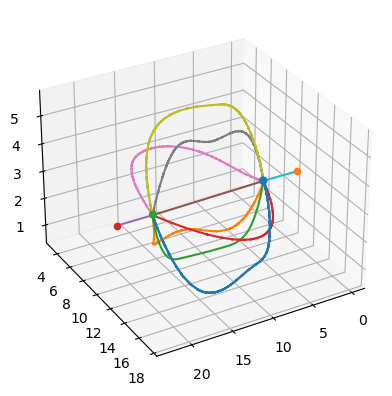

In [51]:
# Plots lines assigning a colour to each line_id    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in line_order[0:10]:
    print(n)
    ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])  

# for n in np.unique(df['line_id'].values):
#     ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# If you need a specific line plotting
n = 2
ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

for n in np.unique(terminal_points['cluster'].values):
    ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
plt.show()

In [46]:
line_order

[9, 2, 3, 1, 10, 6, 4, 5, 7, 8]

In [ ]:
# leftover from when we picked first node based on connectivity
# sorted_connectivity = dict(sorted(connectivity_dict.items(), key=lambda x: x[1]))
# next_node = next(iter(sorted_connectivity))
# next_line = cluster_dict[next_node][0]

# next_line = df[df['z'] == df['z'].min()]['line_id'].values[0]

# lowest = connected_lines[0]
# lowest_z = df[df['line_id'] == lowest]['z'].min()
# for line in connected_lines:
#     z_min = df[df['line_id'] == line]['z'].min()
#     if z_min < lowest_z:
#         lowest = line
#         lowest_z = z_min

# connected_lines = [x for x in connected_lines if x in unprinted_lines]
# If there are connected lines remaining, now print the line with the lowest z value


### Leftover code from Eulerficator
# terminal_points_nogroups = terminal_points.reset_index()
# clusters = terminal_points_nogroups['cluster'].unique()
# lines = terminal_points_nogroups['line_id'].unique()

# # Run through each cluster and create two dictionaries 
# # 1 - cluster numbers as key and the connecting lines as values
# # 2 - cluster numbers as key and the number of connecting nodes as values
# cluster_dict = {}
# connectivity_dict = {}
# for c in clusters:
#     connecting_lines = terminal_points_nogroups[terminal_points_nogroups['cluster'] == c]
#     cluster_dict[c] = list(connecting_lines['line_id'].values)

#     connectivity_dict[c] = len(connecting_lines)

# line_order = []
# while len(line_order) < len(lines):
#     print('line_order:', line_order)
#     print('lines:', lines)
#     # Sort lines by height order - bottom up
#     min_z = df.groupby('line_id')['z'].min()
#     heightsorted_line_ids = min_z.sort_values().index.tolist()
#     unprinted_lines = [n for n in heightsorted_line_ids if n not in line_order]
#     print('unprinted_lines:', unprinted_lines)

#     # Pick the unprinted line with the lowest z-value to start with
#     next_line = unprinted_lines[0]
#     line_order.append(next_line)
#     unprinted_lines = unprinted_lines[1:] # Remove the printed line from the list of remaining lines

#     # Calculate which node you're at - it's the other node to which next_line is connected
#     connected_nodes = terminal_points.loc[next_line]['cluster'].values

#     # Pick the node with the lower z-value
#     start_node = nodes.loc[connected_nodes]['z'].idxmin()
#     end_node = connected_nodes[connected_nodes != start_node][0]

#     connected_lines = cluster_dict[end_node]
#     # Calculate unprinted connected lines in height-order
#     connected_lines = [n for n in unprinted_lines if n in connected_lines]
#     while len(connected_lines) > 0:
#         next_line = connected_lines[0]
#         line_order.append(next_line)
#         unprinted_lines.remove(next_line)
#         # Calculate which node you've moved to
#         connected_nodes = terminal_points.loc[next_line]['cluster'].values
#         start_node = end_node
#         end_node = connected_nodes[connected_nodes != start_node][0]
#         connected_lines = cluster_dict[end_node]

#         # Remove lines that have already been printed
#         connected_lines = [n for n in unprinted_lines if n in connected_lines]
